# **Init**

In [ ]:
import PIL
import time
import torch
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *
from matplotlib.image import imread

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
ROOT = Path("/content/drive/My Drive/Competition/SKELY")

!ls "/content/drive/My Drive/Competition/SKELY" 

data  models  notebooks


In [ ]:
torch.cuda.device(0)
warnings.filterwarnings("ignore")
torch.multiprocessing.freeze_support()
print("[INFO] GPU:", torch.cuda.get_device_name())

[INFO] GPU: Tesla T4


In [ ]:
torch.cuda.empty_cache()

# **Data Loading**

In [ ]:
train_df = pd.read_csv(ROOT/'data/train/train.csv')
test_df = pd.read_csv(ROOT/'data/test/test.csv')

print("[INFO] TRAIN CLASSES: ", train_df.columns.to_list())
print("[INFO] TESR CLASSES: ", test_df.columns.to_list())

display(train_df.head(3))

[INFO] TRAIN CLASSES:  ['filename', 'xRot']
[INFO] TESR CLASSES:  ['filename']


,filename,xRot
0,000000.png,182.835227
1,000001.png,246.988824
2,000002.png,280.845321


In [ ]:
def after_open(img):
    img = img.crop((500, 250, 1500, 1898))
    img.thumbnail((1024,1024))
    return img

data_list = (ImageList.from_df(path=ROOT, df=train_df, cols=['filename'], folder='data/train/train_images', convert_mode='L', after_open=after_open)
                            .split_by_rand_pct(0.1)
                            .label_from_df(cols=['xRot'], label_cls=FloatList))
# test_list = (ImageList.from_df(path=ROOT, df=test_df, cols=['filename'], folder='data/test/test_images', convert_mode='L'))
# data_list.add_test(test_list)

augs = [RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': 1.1}, p=1, resolved={}, do_run=True, is_random=False, use_on_y=False)]
tfms = (augs, augs)

def get_data(image_size, batch_size):
    size = (image_size, round(image_size / 1.651))
    data = (data_list.transform(tfms=tfms, size=size)
                .databunch(bs=batch_size)
                .normalize(imagenet_stats))
    return data

In [ ]:
data = get_data(512,4)

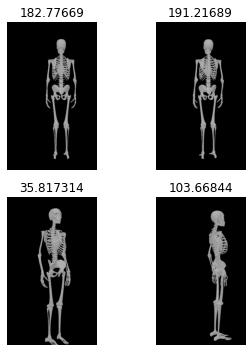

In [ ]:
data.show_batch(4, figsize=(5,5))

In [ ]:
data.label_list

LabelLists;

Train: LabelList (9000 items)
x: ImageList
Image (1, 512, 310),Image (1, 512, 310),Image (1, 512, 310),Image (1, 512, 310),Image (1, 512, 310)
y: FloatList
182.83522,246.98883,280.8453,261.5491,192.65218
Path: /content/drive/My Drive/Competition/SKELY;

Valid: LabelList (999 items)
x: ImageList
Image (1, 512, 310),Image (1, 512, 310),Image (1, 512, 310),Image (1, 512, 310),Image (1, 512, 310)
y: FloatList
333.88574,257.71103,89.09029,115.67846,174.86519
Path: /content/drive/My Drive/Competition/SKELY;

Test: None

In [ ]:
x,y = next(iter(data.train_dl))

In [ ]:
x.shape

torch.Size([4, 3, 512, 512])

In [ ]:
y.shape

torch.Size([4])

# **Model & Training**

In [ ]:
BATCH_SIZE = 32

### 64 * 64

In [ ]:
learn = create_cnn(get_data(64, BATCH_SIZE*2), models.resnet34, metrics=[accuracy, mean_squared_error, mean_absolute_error], pretrained=True)
learn.model_dir = ROOT/'models'
learn.save('resnet_64')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


[INFO] Finding LR1... 


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
WAITING
Min numerical gradient: 8.32E-02
Min loss divided by 10: 1.10E-01


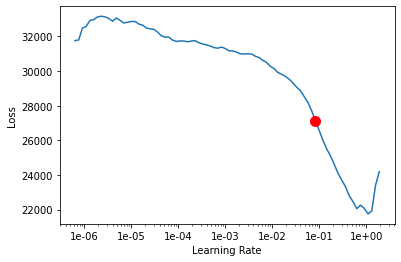

In [ ]:
# Find LR1
print("[INFO] Finding LR1... ")
learn.lr_find()
print("WAITING")
time.sleep(5)
learn.recorder.plot(suggestion=True)

[INFO] Training 1: 


epoch,train_loss,valid_loss,accuracy,mean_squared_error,mean_absolute_error,time
0,9537.034180,66728.015625,0.000000,66728.015625,240.461411,09:50
1,2369.571533,1672.762085,0.000000,1672.762085,37.552444,09:58
2,764.188354,70.692535,0.000000,70.692535,6.493638,09:58
3,380.086639,651.306702,0.000000,651.306702,21.211266,09:56
4,259.193604,15.381530,0.000000,15.381531,3.376326,09:54
5,191.811478,47.119301,0.000000,47.119301,5.939564,09:55


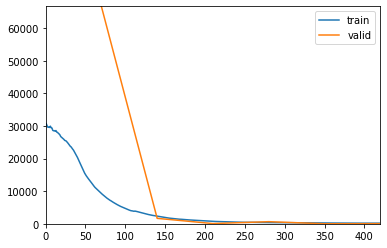

Better model found at epoch 0 with mean_squared_error value: 66728.015625.
Better model found at epoch 1 with mean_squared_error value: 1672.7620849609375.
Better model found at epoch 2 with mean_squared_error value: 70.69253540039062.
Better model found at epoch 4 with mean_squared_error value: 15.38153076171875.


In [ ]:
# Train 1
print("[INFO] Training 1: ")
learn.fit_one_cycle(cyc_len=6, max_lr=1e-01, callbacks=[ShowGraph(learn),
                                                    SaveModelCallback(learn, monitor='mean_squared_error', mode='min', name='resnet_64')])

[INFO] Finding LR2... 


epoch,train_loss,valid_loss,accuracy,mean_squared_error,mean_absolute_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
WAITING
Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.75E-07


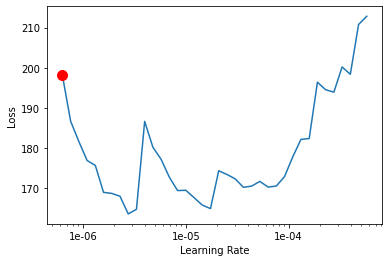

In [ ]:
# Find LR2 after unfreezing
learn.load("resnet_64")
learn.unfreeze()
print("[INFO] Finding LR2... ")
learn.lr_find()
print("WAITING")
time.sleep(5)
learn.recorder.plot(suggestion=True)

[INFO] Training 2: 


epoch,train_loss,valid_loss,accuracy,mean_squared_error,mean_absolute_error,time
0,160.608078,8.444023,0.000000,8.444023,2.395805,10:01
1,162.075424,13.197749,0.000000,13.197750,2.782038,10:00
2,163.497665,8.110780,0.000000,8.110780,2.497982,09:58
3,156.216507,29.465096,0.000000,29.465096,5.348552,10:01


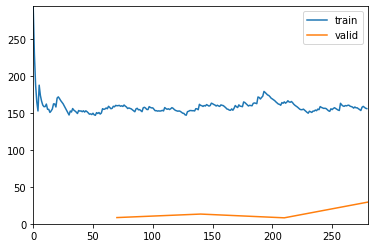

Better model found at epoch 0 with mean_squared_error value: 8.444023132324219.
Better model found at epoch 2 with mean_squared_error value: 8.110779762268066.


In [ ]:
print("[INFO] Training 2: ")
learn.fit_one_cycle(cyc_len=4, max_lr=5e-06, callbacks=[ShowGraph(learn),
                                                    SaveModelCallback(learn, monitor='mean_squared_error', mode='min', name='resnet_64a')])

### 128 * 128

In [ ]:
learn = create_cnn(get_data(128, BATCH_SIZE*2), models.resnet152, metrics=[accuracy, mean_squared_error, mean_absolute_error], pretrained=True)
learn.model_dir = ROOT/'models'
learn.save('resnet_128')

[INFO] Finding LR1... 


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
WAITING
Min numerical gradient: 7.59E-03
Min loss divided by 10: 9.12E-02


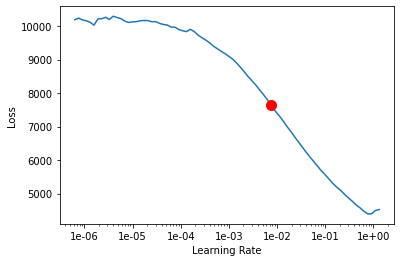

In [ ]:
# Find LR1
learn.load('resnet_64a')
print("[INFO] Finding LR1... ")
learn.lr_find()
print("WAITING")
time.sleep(5)
learn.recorder.plot(suggestion=True)

[INFO] Training 1: 


epoch,train_loss,valid_loss,accuracy,mean_squared_error,mean_absolute_error,time
0,1947.824341,359.923248,0.000000,359.923218,15.789002,10:45
1,539.492188,80.650200,0.000000,80.650192,5.271261,10:38
2,267.081909,31.015436,0.000000,31.015434,4.762248,10:37
3,189.025711,37.093594,0.000000,37.093594,5.552132,10:42
4,159.418030,4.825202,0.000000,4.825202,1.553180,10:41
5,141.336182,9.610626,0.000000,9.610626,2.693943,10:40


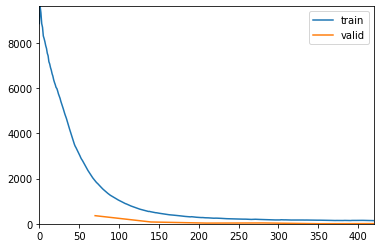

Better model found at epoch 0 with mean_squared_error value: 359.9232177734375.
Better model found at epoch 1 with mean_squared_error value: 80.65019226074219.
Better model found at epoch 2 with mean_squared_error value: 31.01543426513672.
Better model found at epoch 4 with mean_squared_error value: 4.825201988220215.


In [ ]:
# Train 1
print("[INFO] Training 1: ")
learn.fit_one_cycle(cyc_len=6, max_lr=1e-02, callbacks=[ShowGraph(learn),
                                                    SaveModelCallback(learn, monitor='mean_squared_error', mode='min', name='resnet_128')])

[INFO] Finding LR2... 


epoch,train_loss,valid_loss,accuracy,mean_squared_error,mean_absolute_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
WAITING
Min numerical gradient: 6.31E-07
Min loss divided by 10: 7.59E-08


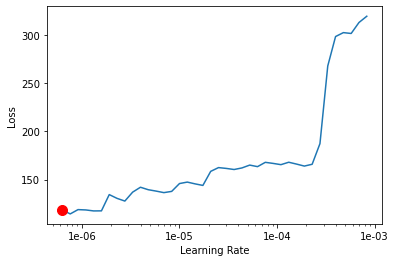

In [ ]:
# Find LR2 after unfreezing
learn.load("resnet_128")
learn.unfreeze()
print("[INFO] Finding LR2... ")
learn.lr_find()
print("WAITING")
time.sleep(5)
learn.recorder.plot(suggestion=True)

[INFO] Training 2: 


epoch,train_loss,valid_loss,accuracy,mean_squared_error,mean_absolute_error,time
0,154.801163,21.021458,0.000000,21.021458,4.433531,11:01
1,138.752411,9.113115,0.000000,9.113114,2.458401,10:47
2,151.248749,13.636316,0.000000,13.636316,3.450802,10:53
3,144.979065,3.875652,0.000000,3.875652,1.406164,10:46


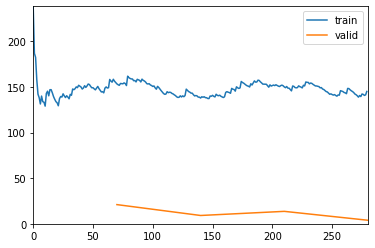

Better model found at epoch 0 with mean_squared_error value: 21.02145767211914.
Better model found at epoch 1 with mean_squared_error value: 9.113114356994629.
Better model found at epoch 3 with mean_squared_error value: 3.8756520748138428.


In [ ]:
print("[INFO] Training 2: ")
learn.fit_one_cycle(cyc_len=4, max_lr=6.5e-7, callbacks=[ShowGraph(learn),
                                                    SaveModelCallback(learn, monitor='mean_squared_error', mode='min', name='resnet_128a')])

### 512 * 512

In [ ]:
learn = create_cnn(get_data(512, BATCH_SIZE//2), models.resnet50, metrics=[accuracy, mean_squared_error, mean_absolute_error], pretrained=True)
learn.model_dir = ROOT/'models'
learn.save('resnet_512')

[INFO] Finding LR1... 


epoch,train_loss,valid_loss,accuracy,mean_squared_error,mean_absolute_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
WAITING
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.32E-01


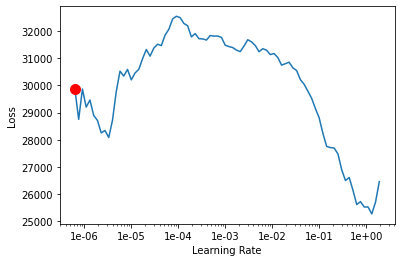

In [ ]:
# Find LR1

# learn.load('resnet_128a')
print("[INFO] Finding LR1... ")
learn.lr_find()
print("WAITING")
time.sleep(5)
learn.recorder.plot(suggestion=True)

[INFO] Training 1: 


epoch,train_loss,valid_loss,accuracy,mean_squared_error,mean_absolute_error,time
0,24459.974609,14014.924805,0.000000,14014.920898,113.800232,39:03
1,1906.014648,1706.862061,0.000000,1706.862061,30.465296,10:22
2,736.492249,288.389404,0.000000,288.389313,8.120374,10:27
3,647.443481,198.052917,0.000000,198.052917,7.873269,10:25
4,571.913147,258.122253,0.000000,258.122253,9.149083,10:25
5,558.157471,209.966660,0.000000,209.966675,5.752133,10:26


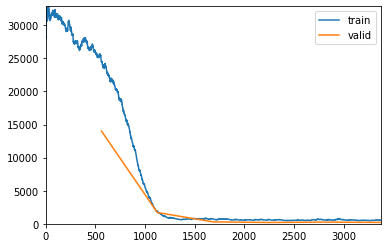

Better model found at epoch 0 with mean_squared_error value: 14014.9208984375.
Better model found at epoch 1 with mean_squared_error value: 1706.862060546875.
Better model found at epoch 2 with mean_squared_error value: 288.3893127441406.
Better model found at epoch 3 with mean_squared_error value: 198.05291748046875.


In [ ]:
# Train 1
print("[INFO] Training 1: ")
learn.fit_one_cycle(cyc_len=6, max_lr=1e-03, callbacks=[ShowGraph(learn),
                                                    SaveModelCallback(learn, monitor='mean_squared_error', mode='min', name='resnet_512')])

[INFO] Finding LR2... 


epoch,train_loss,valid_loss,accuracy,mean_squared_error,mean_absolute_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
WAITING
Min numerical gradient: 7.59E-07
Min loss divided by 10: 1.45E-06


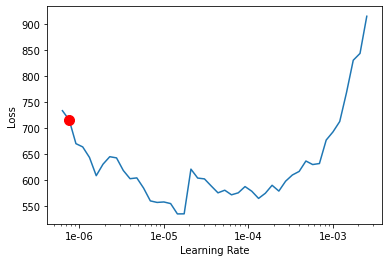

In [ ]:
# Find LR2 after unfreezing
learn.load("resnet_512")
learn.unfreeze()
print("[INFO] Finding LR2... ")
learn.lr_find()
print("WAITING")
time.sleep(5)
learn.recorder.plot(suggestion=True)

[INFO] Training 2: 


epoch,train_loss,valid_loss,accuracy,mean_squared_error,mean_absolute_error,time
0,560.682007,174.665817,0.000000,174.665802,7.006024,11:07
1,478.435944,218.556259,0.000000,218.556274,9.873084,11:08
2,511.508728,85.068573,0.000000,85.068581,7.049075,11:08
3,572.098389,156.234970,0.000000,156.234970,7.169929,11:02


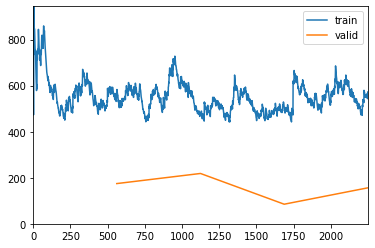

Better model found at epoch 0 with mean_squared_error value: 174.66580200195312.
Better model found at epoch 2 with mean_squared_error value: 85.0685806274414.


In [ ]:
print("[INFO] Training 2: ")
learn.fit_one_cycle(cyc_len=4, max_lr=2e-6, callbacks=[ShowGraph(learn),
                                                    SaveModelCallback(learn, monitor='mean_squared_error', mode='min', name='resnet_512a')])